In [1]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("esp32_rvs.csv")
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.sort_values(by='timestamp')
features = ['temperature', 'humidity', 'pressure','timestamp']
data = data[features]


In [2]:
data

,temperature,humidity,pressure,timestamp
0,27.0,66.3,101.1162,2024-09-18 20:45:08
1,27.4,65.3,101.1098,2024-09-18 20:55:08
2,27.3,65.6,101.1121,2024-09-18 21:05:09
3,27.3,65.7,101.1221,2024-09-18 21:15:08
4,25.7,65.6,101.1272,2024-09-18 21:33:10
...,...,...,...,...
7686,13.3,92.3,101.7065,2024-11-11 05:51:09
7687,13.2,92.1,101.7038,2024-11-11 06:01:09
7688,13.2,92.5,101.7039,2024-11-11 06:11:09
7689,13.2,92.7,101.7020,2024-11-11 06:21:09


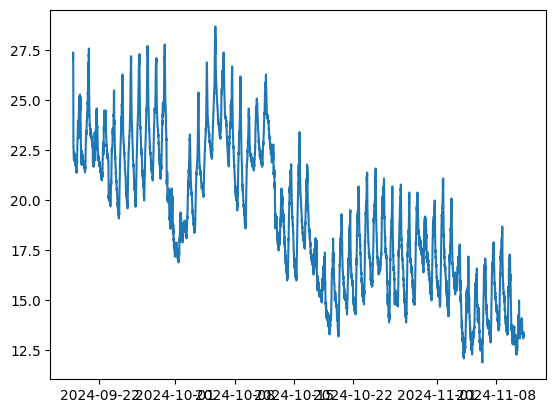

In [3]:
plt.plot(data["timestamp"],data["temperature"])

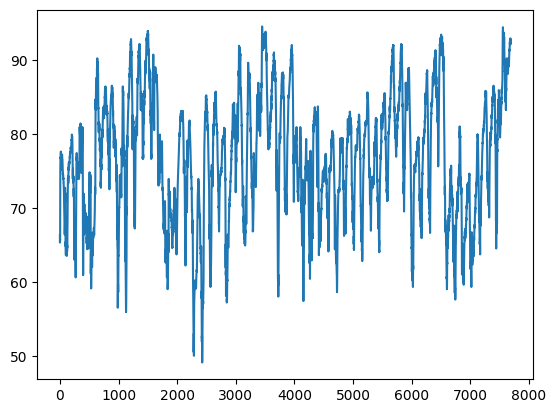

In [4]:
plt.plot(data["humidity"])

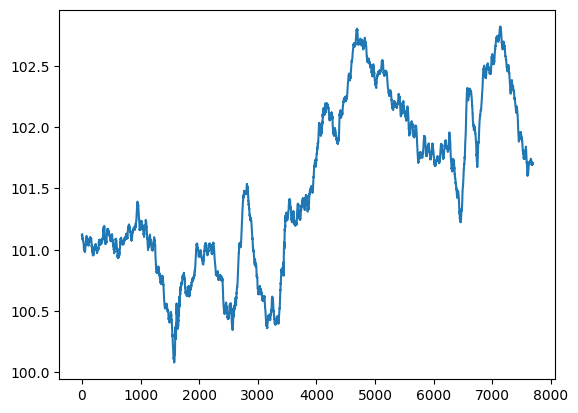

In [5]:
plt.plot(data["pressure"])

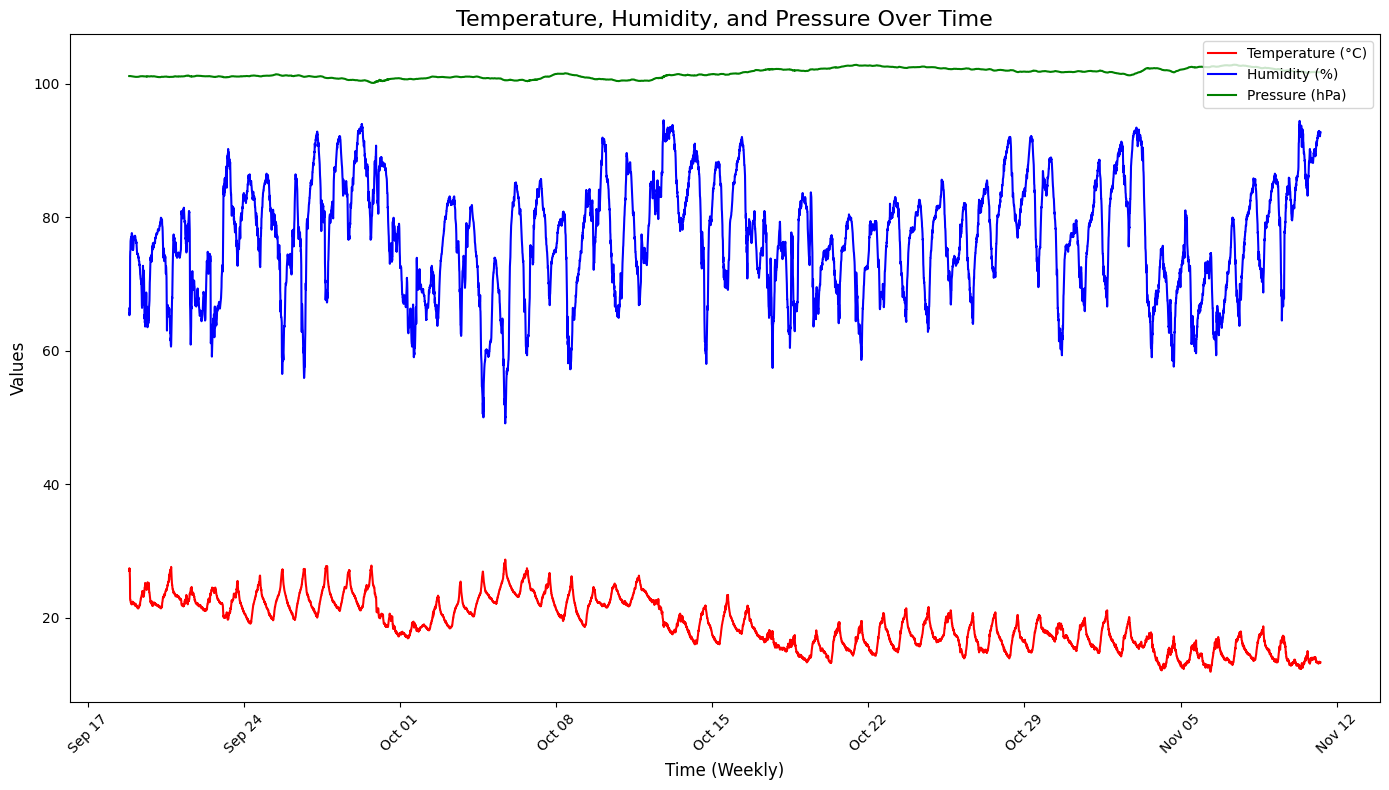

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, WeekdayLocator

data = pd.read_csv("esp32_rvs.csv")
data['timestamp'] = pd.to_datetime(data['timestamp'])
plt.figure(figsize=(14, 8))
plt.plot(data['timestamp'], data['temperature'], label='Temperature (°C)', color='red')
plt.plot(data['timestamp'], data['humidity'], label='Humidity (%)', color='blue')
plt.plot(data['timestamp'], data['pressure'], label='Pressure (hPa)', color='green')


ax = plt.gca()
ax.xaxis.set_major_locator(WeekdayLocator(interval=1))  # Haftalık aralıklar
ax.xaxis.set_major_formatter(DateFormatter('%b %d'))   # Tarih formatı: Ay-Gün

# Grafik başlık ve etiketler
plt.title('Temperature, Humidity, and Pressure Over Time', fontsize=16)
plt.xlabel('Time (Weekly)', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.xticks(rotation=45, fontsize=10)  # X ekseni döndürme
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()

plt.show()


In [ ]:
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader

# Veriyi normalize et (0-1 aralığına)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Zaman serisi için sekans oluşturma
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        target = data[i + sequence_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

sequence_length = 30  # Sekans uzunluğu 30 adım : 300 dakika , 5 saat 
X, y = create_sequences(data_scaled, sequence_length)

 
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

 
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [9]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [ ]:
class LSTMForecastingModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMForecastingModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Sadece son zaman adımını al
        return out

# Model parametreleri
input_size = X_train.shape[2]
hidden_size = 64
num_layers = 2
output_size = X_train.shape[2]

model = LSTMForecastingModel(input_size, hidden_size, num_layers, output_size).to(device)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50
batch_size = 32


train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(list(zip(X_test, y_test)), batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

   
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            test_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Test Loss: {test_loss/len(test_loader):.4f}")

# Tahmin yapma
model.eval()
with torch.no_grad():
    predictions = model(X_test).cpu().numpy()

# Gerçek ve tahmin edilen değerleri geri ölçeklendirme
y_test_unscaled = scaler.inverse_transform(y_test.cpu().numpy())
predictions_unscaled = scaler.inverse_transform(predictions)


Using device: cuda
Epoch 1/50, Train Loss: 0.0354, Test Loss: 0.0058
Epoch 2/50, Train Loss: 0.0020, Test Loss: 0.0016
Epoch 3/50, Train Loss: 0.0008, Test Loss: 0.0007
Epoch 4/50, Train Loss: 0.0006, Test Loss: 0.0006
Epoch 5/50, Train Loss: 0.0006, Test Loss: 0.0007
Epoch 6/50, Train Loss: 0.0005, Test Loss: 0.0004
Epoch 7/50, Train Loss: 0.0004, Test Loss: 0.0004
Epoch 8/50, Train Loss: 0.0004, Test Loss: 0.0004
Epoch 9/50, Train Loss: 0.0004, Test Loss: 0.0004
Epoch 10/50, Train Loss: 0.0003, Test Loss: 0.0002
Epoch 11/50, Train Loss: 0.0003, Test Loss: 0.0003
Epoch 12/50, Train Loss: 0.0003, Test Loss: 0.0002
Epoch 13/50, Train Loss: 0.0003, Test Loss: 0.0003
Epoch 14/50, Train Loss: 0.0003, Test Loss: 0.0002
Epoch 15/50, Train Loss: 0.0002, Test Loss: 0.0002
Epoch 16/50, Train Loss: 0.0002, Test Loss: 0.0002
Epoch 17/50, Train Loss: 0.0002, Test Loss: 0.0002
Epoch 18/50, Train Loss: 0.0002, Test Loss: 0.0002
Epoch 19/50, Train Loss: 0.0002, Test Loss: 0.0002
Epoch 20/50, Train Lo

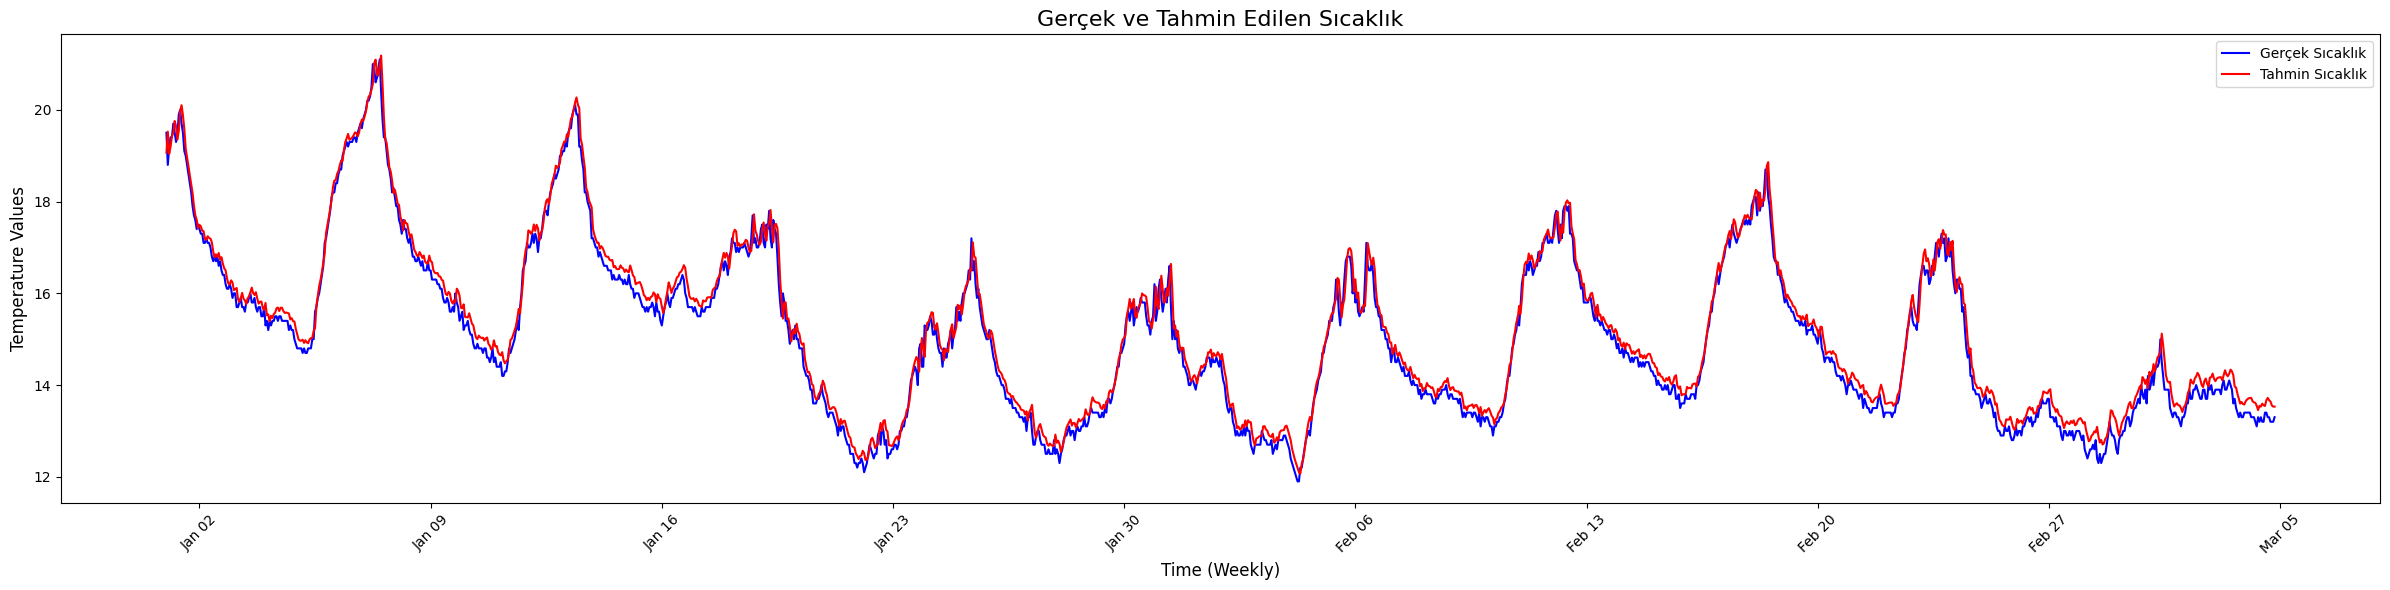

In [ ]:
timestamps = pd.date_range(start='2024-01-01', periods=len(y_test_unscaled), freq='H')  
plt.figure(figsize=(24, 6))


plt.plot(timestamps, y_test_unscaled[:, 0], label="Gerçek Sıcaklık", color="blue")
plt.plot(timestamps, predictions_unscaled[:, 0], label="Tahmin Sıcaklık", color="red")

ax = plt.gca()
ax.xaxis.set_major_locator(WeekdayLocator(interval=1))  
ax.xaxis.set_major_formatter(DateFormatter('%b %d'))   


plt.title("Gerçek ve Tahmin Edilen Sıcaklık", fontsize=16)
plt.xlabel("Time (Weekly)", fontsize=12)
plt.ylabel("Temperature Values", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()

plt.show()
